## SMS Spam Detection using TensorFlow
In today's society, practically everyone has a mobile phone, and they all get communications (SMS/ email) on their phone regularly. But the essential point is that majority of the messages received will be spam, with only a few being ham or necessary communications. Scammers create fraudulent text messages to deceive you into giving them your personal information, such as your password, account number, or Social Security number. If they have such information, they may be able to gain access to your email, bank, or other accounts.

### Load libraries and read data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
# Reading the data
df = pd.read_csv(r".\Data\spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


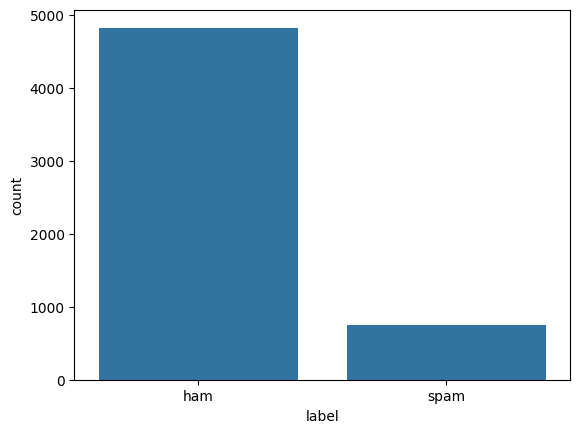

In [7]:
sns.countplot(x=df['label'])
plt.show()

In [8]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

16


In [9]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15686


In [10]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

### Base line model

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [12]:
X_train_vec[0,:]

<1x7733 sparse matrix of type '<class 'numpy.float64'>'
	with 19 stored elements in Compressed Sparse Row format>

### DNN model 1

In [13]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

# Text to vector
text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [14]:
# Get the vocabulary learned by text_vec
vocab = text_vec.get_vocabulary()

print(vocab[:20])  # first 20 tokens
print("Total vocab size:", len(vocab))

word_index = {word: idx for idx, word in enumerate(vocab)}

print(word_index["to"])   # example: might print 57
print(word_index["movie"])  # another word

['', '[UNK]', 'to', 'i', 'you', 'a', 'the', 'u', 'and', 'in', 'is', 'me', 'my', 'for', 'your', 'it', 'of', 'call', 'have', 'on']
Total vocab size: 8508
2
509


In [15]:
# Create an embedding layer
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)

C:\Users\meisa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [16]:
# Input layer: we expect raw text as input (strings)
input_layer = layers.Input(shape=(1,), dtype=tf.string)

# Text vectorization: converts raw string into integer token IDs
vec_layer = text_vec(input_layer)

# Embedding layer: converts integer token IDs into dense vector representations
embedding_layer_model = embedding_layer(vec_layer)

# GlobalAveragePooling: averages embeddings across all tokens in the sequence
x = layers.GlobalAveragePooling1D()(embedding_layer_model)

# Flatten: ensures the pooled output is a flat vector (not 2D shape)
x = layers.Flatten()(x)

# Dense hidden layer: learns higher-level features (32 neurons, ReLU activation)
x = layers.Dense(32, activation='relu')(x)

# Output layer: single neuron with sigmoid activation (for binary classification)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Build the model by specifying input and output
model_1 = keras.Model(input_layer, output_layer)

# Compile model: 
# - Optimizer: Adam (good default for deep learning)
# - Loss: Binary Cross-Entropy (with label smoothing to make training more robust)
# - Metrics: Track accuracy
model_1.compile(
    optimizer='adam',
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.5),
    metrics=['accuracy']
)

In [17]:
# Create datasets to fix the dtype issue
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

# Fit the model
history = model_1.fit(train_dataset,validation_data=test_dataset,epochs=5)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9221 - loss: 0.5984 - val_accuracy: 0.9704 - val_loss: 0.5772
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.5709 - val_accuracy: 0.9758 - val_loss: 0.5739
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9937 - loss: 0.5666 - val_accuracy: 0.9758 - val_loss: 0.5732
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9971 - loss: 0.5648 - val_accuracy: 0.9785 - val_loss: 0.5734
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9975 - loss: 0.5640 - val_accuracy: 0.9776 - val_loss: 0.5738


<Axes: >

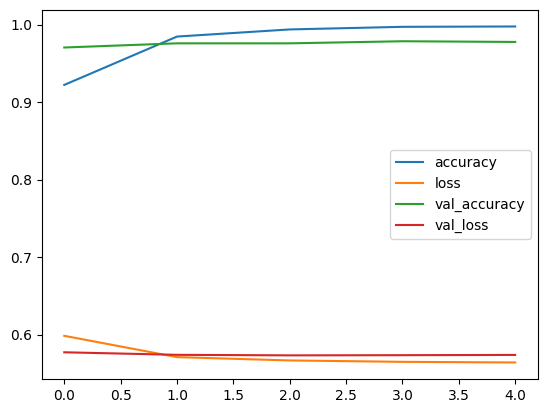

In [18]:
pd.DataFrame(history.history).plot()

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Helper functions
def compile_model(model):
	'''
	simply compile the model with adam optimzer
	'''
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
  '''
  fit the model with given epochs, train
  and test data
  '''
  # Check if validation data is provided
  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test)) #Removed validation steps argument
  else:
      # Handle case where validation data is not provided
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history

In [20]:
# Input layer: takes raw string text as input
input_layer = layers.Input(shape=(1,), dtype=tf.string)

# Text vectorization: converts string text into integer token IDs
vec_layer = text_vec(input_layer)

# Embedding layer: maps token IDs into dense vector embeddings
embedding_layer_model = embedding_layer(vec_layer)

# First Bidirectional LSTM:
# - 64 LSTM units
# - 'tanh' activation (default for LSTMs)
# - return_sequences=True → keep the sequence output for each timestep
bi_lstm = layers.Bidirectional(layers.LSTM(64, activation='tanh', return_sequences=True))(embedding_layer_model)

# Second Bidirectional LSTM:
# - Another 64 LSTM units
# - By default return_sequences=False → only output the last hidden state
# - This summarizes the whole sequence into a single vector
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)

# Flatten layer: ensures the LSTM output is a 1D vector
flatten = layers.Flatten()(lstm)

# Dropout: randomly drops 10% of neurons during training to reduce overfitting
dropout = layers.Dropout(0.1)(flatten)

# Dense hidden layer: 32 neurons, ReLU activation (learns nonlinear patterns)
x = layers.Dense(32, activation='relu')(dropout)

# Output layer: 1 neuron with sigmoid activation (binary classification)
output_layer = layers.Dense(1, activation='sigmoid')(x)

# Build the full model by specifying inputs and outputs
model_2 = keras.Model(input_layer, output_layer)

# Compile the model (compile_model is a helper you defined earlier, likely Adam + BCE + accuracy)
compile_model(model_2)

# Train the model:
# - On train_dataset
# - Validate on test_dataset
# - Run for 5 epochs
history_2 = model_2.fit(train_dataset, validation_data=test_dataset, epochs=5)


Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9746 - loss: 0.0704 - val_accuracy: 0.9749 - val_loss: 0.0930
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9978 - loss: 0.0058 - val_accuracy: 0.9749 - val_loss: 0.1178
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9996 - loss: 0.0025 - val_accuracy: 0.9794 - val_loss: 0.1117
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.0059e-04 - val_accuracy: 0.9812 - val_loss: 0.1339
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.5784e-05 - val_accuracy: 0.9794 - val_loss: 0.1429


<Axes: >

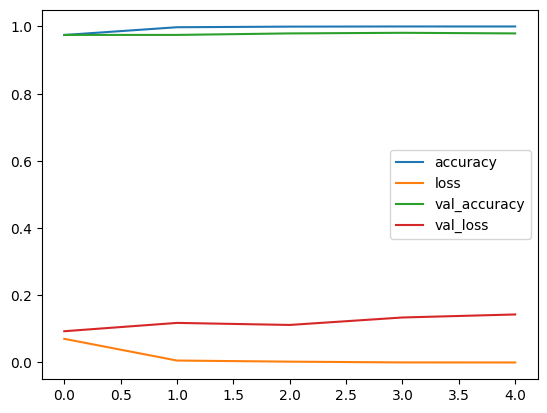

In [21]:
pd.DataFrame(history_2.history).plot()

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Disable XLA compilation (avoids some TF-Hub compatibility issues)
tf.config.optimizer.set_jit(False)

# 1. Input Layer:
# Takes raw text strings as input
input_layer = keras.Input(shape=[], dtype=tf.string)

# 2. Universal Sentence Encoder (USE) Layer:
# Pretrained on large corpus → outputs 512-dim embeddings for each input sentence
# trainable=False → keep pretrained weights frozen
use_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    input_shape=[],
    dtype=tf.string,
    name='USE'
)

# 3. Wrap USE with Lambda Layer:
# Applies the USE layer and explicitly sets its output shape to (512,)
# (since USE always produces 512-d embeddings)
x = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)

# 4. Dropout Layer:
# Randomly drops 20% of neurons during training to reduce overfitting
x = layers.Dropout(0.2)(x)

# 5. Dense Hidden Layer:
# Fully connected layer with 64 units, ReLU activation (nonlinear feature extraction)
x = layers.Dense(64, activation=keras.activations.relu)(x)

# 6. Output Layer:
# Single neuron with sigmoid activation for binary classification
output_layer = layers.Dense(1, activation=keras.activations.sigmoid)(x)

# 7. Build Model:
# Define the model inputs and outputs
model_3 = keras.Model(input_layer, output_layer)
print(model_3.summary())

# 8. Compile Model:
# (compile_model is your helper function, likely using Adam optimizer + BCE loss + accuracy)
compile_model(model_3)

# 9. Train Model:
# Train on train_dataset, validate on test_dataset, for 5 epochs
history_3 = model_3.fit(train_dataset, validation_data=test_dataset, epochs=5)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5



140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9190 - loss: 0.3066 - val_accuracy: 0.9704 - val_loss: 0.1157
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9773 - loss: 0.0853 - val_accuracy: 0.9785 - val_loss: 0.0699
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9829 - loss: 0.0602 - val_accuracy: 0.9830 - val_loss: 0.0588
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9845 - loss: 0.0516 - val_accuracy: 0.9821 - val_loss: 0.0552
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9865 - loss: 0.0460 - val_accuracy: 0.9830 - val_loss: 0.0531


<Axes: >

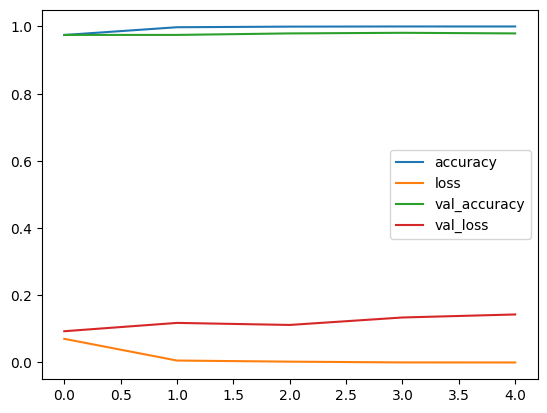

In [25]:
pd.DataFrame(history_2.history).plot()

In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results,
							'Bidirectional-LSTM Model':model_2_results,
							'USE-Transfer learning Model':model_3_results}).transpose()

total_results

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.963229,1.000000,0.724832,0.840467
Custom-Vec-Embedding Model,0.257399,0.035568,0.174497,0.059091
Bidirectional-LSTM Model,0.979372,0.984615,0.859060,0.917563
USE-Transfer learning Model,0.982960,0.945205,0.926174,0.935593
